# Do Language Models Use Their Depth Efficiently?

This notebook uses NDIF to reproduce the main results from the paper [Do Language Models Use Their Depth Efficiently?](https://arxiv.org/abs/2505.13898) (Csordás et al.). This paper investigates how LLMs create their output across layers, finding that layers in the first half contribute significantly more than the second half. The authors found that deeper LLMs appear to use their additional layers for fine-grained adjustments to the residual stream rather than learning qualitatively new types of computation, potentially explaining why scaling transformer depth can have diminishing returns.

Here, we show how to measure each layer's relative contributions (Fig. 2a), cosine similarities to the residual (Fig. 2b), maximum effect on future computations (Fig. 3), refinement effects using LogitLens (Fig 4), residual erasure intervention (Fig 6b), and integrated gradients (Fig 6a).

<br>
📗 Prefer to use Colab? Follow the tutorial [here](https://colab.research.google.com/github/ndif-team/nnsight-docs/blob/mini-papers/source/notebooks/mini-papers/csordas_llm_depth.ipynb)!

## Setup

Import libraries, load models, create helper functions

In [1]:
from IPython.display import clear_output
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    !pip install --no-deps nnsight
    !pip install msgspec python-socketio[client]
    !pip install -U datasets

clear_output()

In [2]:
import os
import nnsight
from nnsight import LanguageModel
from nnsight import CONFIG
import torch
import torch.nn.functional as F
import random
import datasets
from typing import Optional, List, Dict, Tuple
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

/opt/anaconda3/envs/nnsight/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Matplotlib is building the font cache; this may take a moment.


As we are using NNsight, we have the option to access models remotely with NDIF. If you'd like to use NDIF to run this notebook, set `REMOTE = True`. You can set up remote access with NDIF using this tutorial: https://nnsight.net/notebooks/tutorials/start_remote_access/

In [3]:
# Model configuration. For loading a model not supported by NDIF, set REMOTE to False.
REMOTE = True # set to True to use the NDIF hosted model
model_name = "meta-llama/Llama-3.1-8B"

N_EXAMPLES = 2 # Number of examples for the future effect tests.
if REMOTE:
    if is_colab:
        # include your HuggingFace Token and NNsight API key on Colab secrets
        from google.colab import userdata
        NDIF_API = userdata.get('NDIF_API')
        HF_TOKEN = userdata.get('HF_TOKEN')

        CONFIG.set_default_api_key(NDIF_API)
        !huggingface-cli login -token HF_TOKEN
    else:
        nnsight.CONFIG.API.APIKEY = os.environ["NDIF_API"]

clear_output()

KeyError: 'NDIF_API'

In [4]:
if not REMOTE:
    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.bfloat16
    )
    llm = LanguageModel(model_name, device_map="auto", quantization_config=bnb_config, torch_dtype=torch.bfloat16)
else:
    llm = LanguageModel(model_name)

llm.eval()
print(llm)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [5]:
# Dataset for the GSM8K benchmark.
class GSM8K:
    def __init__(self):
        self.dataset = datasets.load_dataset("openai/gsm8k", "main", split="test")

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        # Format GSM8K example according to the LM evaluation harness.
        question = example["question"]
        answer = example["answer"].split("####")
        assert len(answer) == 2
        res = f"Given the following problem, reason and give a final answer to the problem.\nProblem: {question}\nYour response should end with \"The final answer is [answer]\" where [answer] is the response to the problem.\n"
        return f"{res}\n{answer[0]}The final answer is {answer[1].strip()}"

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [6]:
def tokenize(llm: LanguageModel, prompt: str, add_special_tokens: bool = True) -> List[str]:
    # Tokenize a prompt and return the tokens as a list of strings.
    tokens = llm.tokenizer(prompt, add_special_tokens=add_special_tokens)["input_ids"]
    token_str = [s.replace("Ġ","_") for s in llm.tokenizer.convert_ids_to_tokens(tokens)]
    return token_str

## Relative contributions and cosine similarities

We start by analyzing the general behavior of the residual stream. We measure two quantities: the relative contribution to the residual and the cosine similarity of the layer's/sublayer's contribution to the residual. We measure this independently for the MLP, attention, and both of them simultaneously.

This reproduces Fig. 2 from the paper.

In [7]:
def analyze_norms(llm, prompts):
    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            att_cos_all = 0
            mlp_cos_all = 0
            layer_cos_all = 0

            mean_relative_contribution_att = 0
            mean_relative_contribution_mlp = 0
            mean_relative_contribution_layer = 0

            cnt = 0

            for i, prompt in enumerate(prompts):
                with llm.trace(prompt):
                    att_cos = []
                    mlp_cos = []
                    layer_cos = []
                    relative_contribution_att = []
                    relative_contribution_mlp = []
                    relative_contribution_layer = []

                    for i, layer in enumerate(llm.model.layers):
                        # Relative contribution of the attention to the residual stream.

                        layer_inputs = layer.inputs[0][0]
                        self_attn_output = layer.self_attn.output[0]

                        relative_contribution_att.append(
                            (self_attn_output.detach().norm(dim=-1).float() / layer_inputs.detach().norm(dim=-1).float().clamp(min=1e-6)).sum(1).cpu()
                        )

                        # Relative contribution of the MLP to the residual stream. The corresponding
                        # accumulation point is after the self-attention.
                        mlp_input = (self_attn_output + layer_inputs).detach()
                        mlp_output = layer.mlp.output
                        relative_contribution_mlp.append(
                            (mlp_output.detach().norm(dim=-1).float() / mlp_input.norm(dim=-1).clamp(min=1e-6).float()).sum(1).cpu()
                        )

                        # Relative contribution of the layer to the residual stream.
                        layer_output = layer.output[0]
                        layer_diff = (layer_output - layer_inputs).detach()
                        relative_contribution_layer.append(
                            (layer_diff.norm(dim=-1).float() / layer_inputs.detach().norm(dim=-1).float().clamp(min=1e-6)).sum(1).cpu()
                        )

                        # Cosine similarities between the same points as the relative contributions above.
                        att_cos.append(F.cosine_similarity(self_attn_output.detach(), layer_inputs.detach(), dim=-1).sum(1).cpu().float())
                        mlp_cos.append(F.cosine_similarity(mlp_output.detach(), mlp_input, dim=-1).sum(1).cpu().float())
                        layer_cos.append(F.cosine_similarity(layer_diff, layer_inputs.detach(), dim=-1).sum(1).cpu().float())

                        if i == 0:
                            cnt += layer_output.shape[1]

                    mean_relative_contribution_att += torch.cat(relative_contribution_att, dim=0)
                    mean_relative_contribution_mlp += torch.cat(relative_contribution_mlp, dim=0)
                    mean_relative_contribution_layer += torch.cat(relative_contribution_layer, dim=0)

                    att_cos_all += torch.cat(att_cos, dim=0)
                    mlp_cos_all += torch.cat(mlp_cos, dim=0)
                    layer_cos_all += torch.cat(layer_cos, dim=0)

            att_cos_all = (att_cos_all / cnt).save()
            mlp_cos_all = (mlp_cos_all / cnt).save()
            layer_cos_all = (layer_cos_all / cnt).save()

            mean_relative_contribution_att = (mean_relative_contribution_att / cnt).save()
            mean_relative_contribution_mlp = (mean_relative_contribution_mlp / cnt).save()
            mean_relative_contribution_layer = (mean_relative_contribution_layer / cnt).save()

    return (mean_relative_contribution_att, mean_relative_contribution_mlp, mean_relative_contribution_layer,
            att_cos_all, mlp_cos_all, layer_cos_all)


In [8]:
prompts = []
for i, prompt in enumerate(GSM8K()):
    if i >= N_EXAMPLES:
        break
    prompts.append(prompt)

rc_att, rc_mlp, rc_layer, att_cos, mlp_cos, layer_cos = analyze_norms(llm, prompts)

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

[2025-09-19 12:45:16] [34d6b941-520c-4674-a2f9-aa2e3f70ab39] RECEIVED   : Your job has been received and is waiting to be queued.
[2025-09-19 12:45:16] [34d6b941-520c-4674-a2f9-aa2e3f70ab39] QUEUED     : Your job has been recieved by the coordinator and is waiting to be queued.
[2025-09-19 12:45:16] [34d6b941-520c-4674-a2f9-aa2e3f70ab39] QUEUED     : Task 34d6b941-520c-4674-a2f9-aa2e3f70ab39 has been added to the queue. Currently at position 1
[2025-09-19 12:45:16] [34d6b941-520c-4674-a2f9-aa2e3f70ab39] DISPATCHED : Dispatching task...
[2025-09-19 12:45:17] [34d6b941-520c-4674-a2f9-aa2e3f70ab39] RUNNING    : Your job has started running.
[2025-09-19 12:45:18] [34d6b941-520c-4674-a2f9-aa2e3f70ab39] COMPLETED  : Your job has been completed.


In [9]:
def sort_zorder(bars):
    for group in zip(*[container for container in bars]):
        # 'group' is a tuple of bar objects at one x position from different groups.
        z = len(group)
        # Sort the bars by height (lowest first).
        for bar in sorted(group, key=lambda b: abs(b.get_height())):
            bar.set_zorder(z)
            z -= 1

In [10]:
def plot_residual_stats(att, mlp, layer):
    plt.figure(figsize=(6,3))
    bars = []
    bars.append(plt.bar([x for x in range(len(llm.model.layers))], att.float().cpu().numpy(), label="Attention", width=1.1))
    bars.append(plt.bar([x for x in range(len(llm.model.layers))], mlp.float().cpu().numpy(), label="MLP", width=1.1))
    bars.append(plt.bar([x for x in range(len(llm.model.layers))], layer.float().cpu().numpy(), label="Attention + MLP", width=1.1))
    plt.legend()
    sort_zorder(bars)
    plt.xlim(-0.5, len(llm.model.layers)-0.5)
    plt.xlabel("Layer index ($l$)")

Text(0, 0.5, 'Mean Relative Contribution')

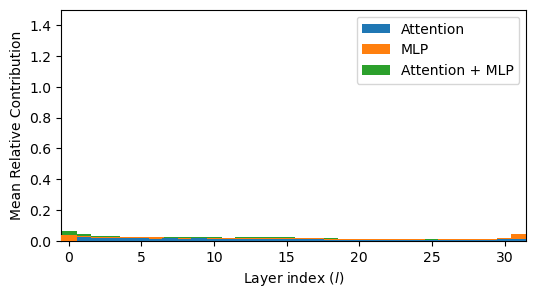

In [11]:
plot_residual_stats(rc_att, rc_mlp, rc_layer)
plt.ylim(0, 1.5)
plt.ylabel("Mean Relative Contribution")

We see reduced contribution in the second half of the layers.

Text(0, 0.5, 'Cosine similarity')

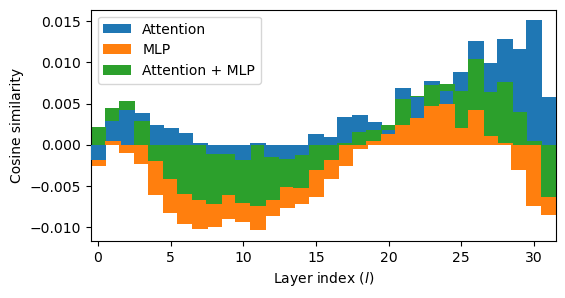

In [12]:
plot_residual_stats(att_cos, mlp_cos, layer_cos)
plt.ylabel("Cosine similarity")

Negative cosine similarities indicate erasing information from the residual, while the positive ones indicate strengthening. Writing new features orthogonal to the current content does not show up in these plots. This intuition does not take into account features in superposition.

## Measuring the effect of the layer on future computations

Here, we measure how the contribution of future layers to the residual change when a previous layer is skipped. The future layer's contribution is the sum of the output of the attention and MLP layers for pre-layernorm transformers. The relative change is defined by the L2 norm of the change normalized by the L2 norm of the original contribution.  This will give us a pairwise metric between layers, showing how much they depend on each other.

Each layer is skipped, and its effect is measured over all future layers. Two setups are possible:
- Effect on all tokens, including the current
- Skipping the layer until position t, and measuring the effect on positions t' > t. This highlights if the skipped layer takes part in a mechanism composed of multiple tokens, such as induction heads.

In [13]:
def merge_io(intervened: torch.Tensor, orig: torch.Tensor, t: Optional[int] = None, no_skip_front: int = 1) -> torch.Tensor:
    # Merge intervened and original inputs. If t is not None, keep the intervened input until t, otherwise keep it everywhere.
    # It does not intervene on the first no_skip_front tokens.
    outs = [orig[:, :no_skip_front]]
    if t is not None:
        outs.append(intervened[:, no_skip_front:t].to(orig.device))
        outs.append(orig[:, t:])
    else:
        outs.append(intervened[:, no_skip_front:].to(orig.device))

    return torch.cat(outs, dim=1)


def get_future(data: torch.Tensor, t: Optional[int]) -> torch.Tensor:
    # Get future tokens from position t onwards. If t is None, return all tokens.
    if t is not None:
        return data[:, t:]
    else:
        return data


def test_effect(llm: LanguageModel, prompt: str, positions: List[Optional[int]], no_skip_front: int = 1) -> tuple[torch.Tensor, torch.Tensor]:
    # Test effect of skipping a layer on all future layers and the output probabilities.
    # If multiple positions are provided, the maximum is taken over all positions.
    # If position is None, it measures the effect on all tokens, not just the future.
    # Note: Detach must be explicitly called on each saved tensor, ortherwise the graph will be kept and it will run out of memory.
    # This is despite being wrapped in torch.no_grad().


    # The idea is to run all interventions in a single session to avoid downloading intermediate activations,
    # which can be very large. The output of matmul in bfloat16 is sensitive to the kernel used by cuBLAS,
    # which changes with the batch size. So run everything in a single batch.

    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:

            dall = torch.zeros(1)
            dall_out = torch.zeros(1)

            residual_log = []

            # Run the model to get the original residuals and output probabilities.
            with llm.trace(prompt) as tracer:
                for i, layer in enumerate(llm.model.layers):
                    if i == 0:
                        residual_log.clear()
                    residual_log.append(layer.output[0].detach().cpu().float() - layer.inputs[0][0].detach().cpu().float())

                residual_log = torch.cat(residual_log, dim=0)
                outputs = llm.output.logits.detach().float().softmax(dim=-1).cpu()

            # Do intervention on each position.
            for t in positions:
                diffs = []
                out_diffs = []

                # Do intervention on each layer.
                for lskip in range(len(llm.model.layers)):
                    with llm.trace(prompt) as tracer:
                        new_logs = []

                        # Log all the layer outputs.
                        for i, layer in enumerate(llm.model.layers):

                            layer_inputs = layer.inputs[0][0]
                            # skip the layer
                            if i == lskip:

                                layer_output = layer.output[0]
                                layer.output = (merge_io(layer_inputs, layer_output, t, no_skip_front), layer.output[1:])

                            new_logs.append((layer.output[0].detach().cpu().float() - layer_inputs.detach().cpu().float()))

                        new_logs = torch.cat(new_logs, dim=0).float()

                        # Measure the relative difference of the residuals on the future tokens
                        relative_diffs = (get_future(residual_log, t) - get_future(new_logs, t)).norm(dim=-1) / get_future(residual_log, t).norm(dim=-1).clamp(min=1e-6)

                        # Take the max realtive difference over the sequence lenght
                        diffs.append(relative_diffs.max(dim=-1).values)

                        # Measure the max relative difference of the output probabilities on the future tokens
                        out_diffs.append((get_future(llm.output.logits.detach(), t).float().softmax(dim=-1).cpu() - get_future(outputs, t)).norm(dim=-1).max(dim=-1).values)

                # Concatenate effects over all layers.
                dall = torch.max(dall, torch.stack(diffs, dim=0))
                dall_out = torch.max(dall_out, torch.stack(out_diffs, dim=0))

            dall = dall.save()
            dall_out = dall_out.save()
    return dall, dall_out


In [14]:
def plot_layer_diffs(dall: torch.Tensor) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(10,3))
    im = ax.imshow(dall.float().cpu().numpy(), vmin=0, vmax=1, interpolation="nearest")
    plt.ylabel("Layer skipped")
    plt.xlabel("Effect @ layer")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.2, pad=0.1)
    cbar = fig.colorbar(im, cax=cax, label='Relative change')
    return fig


def plot_logit_diffs(dall: torch.Tensor) -> plt.Figure:
    fig = plt.figure(figsize=(6,3))
    dall = dall.squeeze()
    plt.bar(list(range(dall.shape[0])), dall)
    plt.xlim(-1, dall.shape[0])
    plt.xlabel("Layer")
    plt.ylabel("Output change norm")
    return fig


In [15]:
def plot_effects(llm: LanguageModel, n_examples: int, test_fn):
    random.seed(123)

    max_future_layer = torch.zeros([1])
    max_future_out = torch.zeros([1])
    for idx, prompt in enumerate(GSM8K()):
        diff_now, diff_out = test_fn(llm, prompt)
        max_future_layer = torch.max(max_future_layer, diff_now)
        max_future_out = torch.max(max_future_out, diff_out)

        if idx == n_examples - 1:
            break

    plot_layer_diffs(max_future_layer)
    plot_logit_diffs(max_future_out)

In [16]:
def test_future_max_effect(llm: LanguageModel, prompt: str, N_CHUNKS: int = 4):
    # Sample N_CHUNKS positions to intervene on and calculate the maximum effect on this single prompt.
    tokens = tokenize(llm, prompt)

    positions = list(range(8, len(tokens)-4, 8))
    random.shuffle(positions)
    positions = positions[:N_CHUNKS]

    return test_effect(llm, prompt, positions)

plot_effects(llm, N_EXAMPLES, test_future_max_effect)

[2025-09-19 12:45:42] [584b0a78-27de-4917-8714-6f9790a514f0] RECEIVED   : Your job has been received and is waiting to be queued.
[2025-09-19 12:45:42] [584b0a78-27de-4917-8714-6f9790a514f0] QUEUED     : Your job has been recieved by the coordinator and is waiting to be queued.
[2025-09-19 12:45:42] [584b0a78-27de-4917-8714-6f9790a514f0] QUEUED     : Task 584b0a78-27de-4917-8714-6f9790a514f0 has been added to the queue. Currently at position 1
[2025-09-19 12:45:43] [584b0a78-27de-4917-8714-6f9790a514f0] DISPATCHED : Dispatching task...


RemoteException: Traceback (most recent call last):
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/deployments/modeling/base.py", line 190, in __call__
    inputs = self.pre()
             ^^^^^^^^^^
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/ray/util/tracing/tracing_helper.py", line 463, in _resume_span
    return method(self, *_args, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/deployments/modeling/base.py", line 241, in pre
    request = self.request.deserialize(self.protected_model)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/schema/request.py", line 64, in deserialize
    return RequestModel.deserialize(model, request, self.zlib)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/nnsight/schema/request.py", line 44, in deserialize
    request:RequestModel = load(data.read(), model)
                           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/nnsight/intervention/serialization.py", line 58, in load
    return CustomCloudUnpickler(io.BytesIO(data), model, frame).load()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/security/protected_environment.py", line 153, in __call__
    raise ImportError(f"Module {name} is not whitelisted")
ImportError: Module _operator is not whitelisted

Module _operator is not whitelisted
Remote exception.

We can see that the second half of the layers does not have a significant effect on the computations in the future tokens. This indicates that they are not constructing reusable features that can be used compositionally in future computations.

2025-07-03 16:47:13,758 6eee1203-93d8-4417-b2d3-48ab3f593438 - RECEIVED: Your job has been received and is waiting approval.
INFO:nnsight_remote:6eee1203-93d8-4417-b2d3-48ab3f593438 - RECEIVED: Your job has been received and is waiting approval.
2025-07-03 16:47:13,925 6eee1203-93d8-4417-b2d3-48ab3f593438 - APPROVED: Your job was approved and is waiting to be run.
INFO:nnsight_remote:6eee1203-93d8-4417-b2d3-48ab3f593438 - APPROVED: Your job was approved and is waiting to be run.
2025-07-03 16:47:19,674 6eee1203-93d8-4417-b2d3-48ab3f593438 - RUNNING: Your job has started running.
INFO:nnsight_remote:6eee1203-93d8-4417-b2d3-48ab3f593438 - RUNNING: Your job has started running.
2025-07-03 16:47:25,286 6eee1203-93d8-4417-b2d3-48ab3f593438 - COMPLETED: Your job has been completed.
INFO:nnsight_remote:6eee1203-93d8-4417-b2d3-48ab3f593438 - COMPLETED: Your job has been completed.


2025-07-03 16:47:39,379 7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - RECEIVED: Your job has been received and is waiting approval.
INFO:nnsight_remote:7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - RECEIVED: Your job has been received and is waiting approval.
2025-07-03 16:47:39,546 7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - APPROVED: Your job was approved and is waiting to be run.
INFO:nnsight_remote:7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - APPROVED: Your job was approved and is waiting to be run.
2025-07-03 16:47:41,355 7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - RUNNING: Your job has started running.
INFO:nnsight_remote:7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - RUNNING: Your job has started running.
2025-07-03 16:47:45,904 7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - COMPLETED: Your job has been completed.
INFO:nnsight_remote:7ed9e7ca-8f70-4ae1-ad93-9f56c971449d - COMPLETED: Your job has been completed.


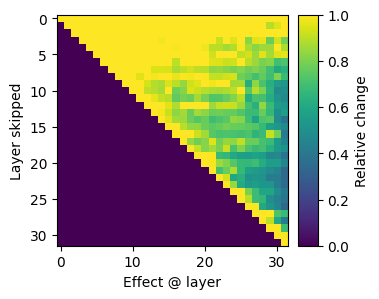

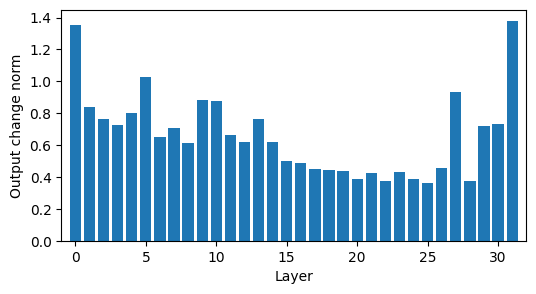

In [19]:
def test_all_max_effect(llm: LanguageModel, prompt: str, N_CHUNKS: int = 4):
    return test_effect(llm, prompt, [None])

plot_effects(llm, N_EXAMPLES, test_all_max_effect)

The second half of the layers remain important for the current predictions. However, they seem to have a reduced effect on each other. This indicates that they are independently refining the final predictions.

## Logit Lens

Here, we use logit lens to show that the second half of the layers is responsible for refining the final predictions for each layer, reproducing Fig 4. in the paper.

In [27]:
def run_logitlens(llm, prompts, K=5):

    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:

            res_kl_divs = 0
            res_overlaps = 0
            cnt = 0
            N_layers = len(llm.model.layers)

            # Iterate over all prompts.
            for prompt in prompts:
                kl_divs = []
                overlaps = []
                layer_logs = []

                # Iterate over all layers first and get the final logits.
                with llm.trace(prompt):
                    for l in range(len(llm.model.layers)):
                        # Run the LM head and final layernorm on each layer's output
                        tap = llm.model.layers[l].inputs[0][0]
                        layer_logs.append(llm.lm_head(llm.model.norm(tap)).detach().float())
                    out_logits = llm.output.logits

                # Compute the final logprobs and top-K predictions
                lout = out_logits.float().log_softmax(-1)
                otopl = lout.topk(K, dim=-1).indices

                # 1 for each token in the top-K, 0 for others.
                real_oh = F.one_hot(otopl, llm.model.embed_tokens.weight.shape[0]).sum(-2)

                for l in range(len(llm.model.layers)):
                    # Compute the KL divergence between the final output and the logitlens outputs.
                    llayer = layer_logs[l].log_softmax(-1)

                    kl_divs.append((llayer.exp() * (llayer - lout)).sum(-1).sum().detach())

                    # Also compute the top-K predictions for each layer.
                    itopl = llayer.topk(K, dim=-1).indices

                    # Compute the top-K mask for the logitlens predictions
                    logitlens_oh = F.one_hot(itopl.to(real_oh.device), llm.model.embed_tokens.weight.shape[0]).sum(-2)

                    # Compute overlap
                    overlaps.append((logitlens_oh.unsqueeze(-2).float() @ real_oh.unsqueeze(-1).float() / K).sum())


                res_kl_divs = res_kl_divs + torch.stack(kl_divs, dim=0)
                res_overlaps = res_overlaps + torch.stack(overlaps, dim=0)
                cnt += out_logits.shape[1]

            res_kl_divs = res_kl_divs / cnt
            res_overlaps = res_overlaps / cnt

            res_kl_divs = res_kl_divs.save()
            res_overlaps = res_overlaps.save()

    return res_kl_divs, res_overlaps

In [28]:
res_kl_divs, res_overlaps = run_logitlens(llm, prompts)

[2025-09-19 13:03:58] [fca65770-b96c-4c53-b59e-e7e7fa97a52c] RECEIVED   : Your job has been received and is waiting to be queued.
[2025-09-19 13:03:58] [fca65770-b96c-4c53-b59e-e7e7fa97a52c] QUEUED     : Your job has been recieved by the coordinator and is waiting to be queued.
[2025-09-19 13:03:58] [fca65770-b96c-4c53-b59e-e7e7fa97a52c] QUEUED     : Task fca65770-b96c-4c53-b59e-e7e7fa97a52c has been added to the queue. Currently at position 1
[2025-09-19 13:03:58] [fca65770-b96c-4c53-b59e-e7e7fa97a52c] DISPATCHED : Dispatching task...
[2025-09-19 13:04:00] [fca65770-b96c-4c53-b59e-e7e7fa97a52c] RUNNING    : Your job has started running.


RemoteException: Traceback (most recent call last):
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/deployments/modeling/base.py", line 205, in __call__
    result = await job_task
             ^^^^^^^^^^^^^^
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/asyncio/threads.py", line 25, in to_thread
    return await loop.run_in_executor(None, func_call)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/ray/util/tracing/tracing_helper.py", line 463, in _resume_span
    return method(self, *_args, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/deployments/modeling/base.py", line 275, in execute
    result = RemoteExecutionBackend(request.interventions, self.execution_protector)(request.tracer)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/backend.py", line 27, in __call__
    run(tracer, self.fn)
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/sandbox.py", line 16, in run
    raise wrap_exception(e,tracer.info) from None
nnsight.NNsightException: 

Traceback (most recent call last):
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/sandbox.py", line 14, in run
    tracer.execute(fn)
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/nnsight/intervention/tracing/base.py", line 312, in execute
    fn(self, self.info)
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/sandbox.py", line 8, in run
    N_layers = len(llm.model.layers)
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/nnsight/intervention/envoy.py", line 898, in __len__
    return len(self._module)
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/security/protected_objects.py", line 80, in __getattribute__
    raise ValueError(f"Attribute '{name}' is not allowed")

ValueError: Attribute '_module' is not allowed



Traceback (most recent call last):
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/sandbox.py", line 14, in run
    tracer.execute(fn)
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/nnsight/intervention/tracing/base.py", line 312, in execute
    fn(self, self.info)
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/sandbox.py", line 8, in run
    N_layers = len(llm.model.layers)
  File "/u/svcndifuser/miniconda3/envs/service/lib/python3.12/site-packages/nnsight/intervention/envoy.py", line 898, in __len__
    return len(self._module)
  File "/u/svcndifuser/ndif-deployment/repos/prod/ndif/src/services/ray/src/ray/nn/security/protected_objects.py", line 80, in __getattribute__
    raise ValueError(f"Attribute '{name}' is not allowed")

ValueError: Attribute '_module' is not allowed
Remote exception.

Text(0.5, 0, 'Layer')

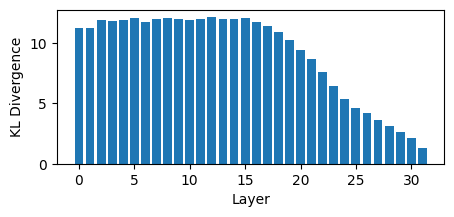

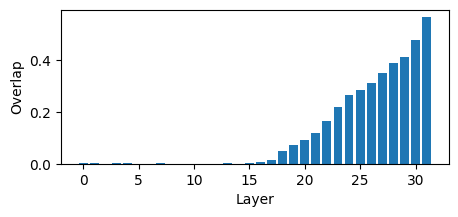

In [22]:
plt.figure(figsize=(5,2))
plt.bar(range(len(llm.model.layers)), res_kl_divs.cpu().numpy())
plt.ylabel("KL Divergence")
plt.xlabel("Layer")

plt.figure(figsize=(5,2))
plt.bar(range(len(llm.model.layers)), res_overlaps.cpu().numpy())
plt.ylabel("Overlap")
plt.xlabel("Layer")

This shows that at the same point where the contribution to the future computations drops, the KL divergence to the output also drops, and the overlap with the final predictions starts to grow rapidly, confirming our hypothesis that the second half of the layers are refining the output probability distributions.

## Residual erasure experiment

Measure the layer in which each token is processed. The hypothesis is that if the computation is compositional, earlier operations should finish in a lower layer, such that the later operations can take subresults as their inputs. We should see a left-to-right tiled plot here if the model is compositional.

To measure this, we compute an "uninformative" residual for each layer. This is an average of 10 GSM8K examples. Then, for each token and each layer, we replace the residual `h[token, layer]` with the uninformative one and check its effect on the answer tokens.

In [23]:
def measure_token_skip(llm: LanguageModel, q: str, a: str, prompts: List[str]) -> Tuple[torch.Tensor, List[str]]:
    # Replace each position in the residual stream (each layer + each token) with an uninformative
    # value and measure the effect on the answer.
    # Returns the effect map of shape (layers, tokens) and the the string token IDs.
    atokens = tokenize(llm, a, add_special_tokens=False)
    alen = len(atokens)

    prompt = q + a

    tokens = tokenize(llm, prompt)

    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            # Collect uninformative residuals from 10 GSM8K examples
            baseline_residuals = {
                i: 0 for i in range(len(llm.model.layers)+1)
            }
            count = 0

            for i, nprompt in enumerate(prompts):

                with llm.trace(nprompt):
                    for l in range(len(llm.model.layers)):
                        if l == 0:
                            # Special handling for the token embedding from before the first layer
                            baseline_residuals[0] += llm.model.layers[0].inputs[0][0].detach().sum(dim=1).cpu().float()
                        baseline_residuals[l+1] += llm.model.layers[l].output[0].detach().sum(dim=1).cpu().float()
                    count += llm.model.layers[0].output[0].shape[1]

            baseline_residuals = {k: (v / count) for k, v in baseline_residuals.items()}

            # Measure the output probability distribution without intervention
            with llm.trace(prompt):
                outs = llm.output.logits[:, -(alen+1):-1].detach().softmax(dim=-1)

            ls = []
            for l in range(len(llm.model.layers) + 1):
                ts = []
                for t in range(len(tokens)):
                    with llm.trace(prompt):
                        if l == 0:
                            # Intervene on the embeddings
                            layer = llm.model.layers[0]
                            layer.inputs[0][0][:, t] = baseline_residuals[l][:, None]
                        else:
                            # Intervene on the layer output
                            layer = llm.model.layers[l-1]
                            layer.output[0][:, t] = baseline_residuals[l][:, None]

                        # Measure the max effect on the output probability of any answer token
                        ts.append((outs - llm.output.logits[:, -(alen+1):-1].detach().softmax(dim=-1)).norm(dim=-1).max(dim=1).values.cpu())

                # Concatenate the token effects (a row of the plot)
                ls.append(torch.cat(ts, 0))

            # Concatenate layers (columns of the plot)
            result = torch.stack(ls, dim=0).save()

    return result, tokens

In [24]:
def plot_logit_effect(ls: torch.Tensor, tokens: List[str]) -> plt.Figure:
    ls = ls[:, :-1]
    tokens = tokens[:-1]
    tokens = [t if t != "<|begin_of_text|>" else "BOS" for t in tokens]
    fig, ax = plt.subplots(figsize=(5,5 * max(1, ls.shape[0] / 30)))
    im = ax.imshow(ls.float().cpu().numpy())
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right',rotation_mode="anchor", fontsize=8)
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.1, pad=0.1)
    cbar = fig.colorbar(im, cax=cax, label='Probability Difference Norm')
    return fig

In [25]:
promtps_10 = []

for i, prompt in enumerate(GSM8K()):
    if i >= 10:
        break
    promtps_10.append(prompt)

erasure_effect, tokens = measure_token_skip(llm, "5 + 7 + 5 + 3 + 1 + 7 = ", "28", promtps_10)

2025-07-03 16:48:24,094 3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - RECEIVED: Your job has been received and is waiting approval.
INFO:nnsight_remote:3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - RECEIVED: Your job has been received and is waiting approval.
2025-07-03 16:48:24,261 3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - APPROVED: Your job was approved and is waiting to be run.
INFO:nnsight_remote:3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - APPROVED: Your job was approved and is waiting to be run.
2025-07-03 16:48:26,448 3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - RUNNING: Your job has started running.
INFO:nnsight_remote:3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - RUNNING: Your job has started running.
2025-07-03 16:48:51,194 3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - COMPLETED: Your job has been completed.
INFO:nnsight_remote:3e7dc3c5-8f32-4486-9c61-419aa1e4db6f - COMPLETED: Your job has been completed.


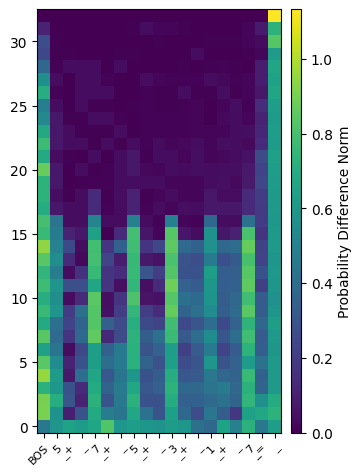

In [26]:
plot_logit_effect(erasure_effect, tokens)
None

We see that each token is important until the same point in the residual, indicating that no high-level composition is happening.

## Integrated Gradients

Integrated gradients can give a direct importance metric for any computation in the network. By measuring the importance of the residual stream for each token and layer separately, we can obtain a similar plot to the residual erasure experiments.

We will see that the two plots show the same picture: all tokens are important until halfway through the network.

In [27]:
def get_igrads(llm, q: str, a: str):
    N_STEPS = 256     # How many total integration steps to take
    BLOCK_SIZE = 16   # Batch size for the integration steps

    atok = tokenize(llm, a, add_special_tokens=False)
    alen = len(atok)

    prompt = q + a

    alltok = tokenize(llm, prompt)

    with llm.session(remote=REMOTE) as session:

        igrads = []
        for l in range(len(llm.model.layers)):
            l_igrads = 0

            for step_block in range(0, N_STEPS, BLOCK_SIZE):
                with llm.trace(prompt) as tracer:
                    orig_output = llm.model.layers[l].output[0].clone().detach()

                    # Set the baseline to the mean activation
                    baseline = orig_output.mean(dim=1, keepdims=True)

                    # Create a bunch of interpolated activations between the original activation and the baseline
                    # This also creates a batch from the single example that we had before this layer.
                    r = torch.arange(start=step_block, end=min(step_block + BLOCK_SIZE, N_STEPS), device=baseline.device, dtype=baseline.dtype) / N_STEPS
                    target = orig_output * r[:, None, None] + baseline * (1-r[:, None, None])

                    # Overwrite the MLP output with the target
                    llm.model.layers[l].output = target,
                    llm.model.layers[l].output[0].requires_grad_()

                    # Get the probability of the ground truth tokens. The GT token is the input of the
                    # embedding layer.
                    oclasses = F.softmax(llm.output.logits[:, :-1], dim=-1)
                    tid = llm.model.embed_tokens.inputs[0][0][:, 1:]

                    tid = tid.repeat(oclasses.shape[0], 1)
                    oprobs = oclasses.gather(-1, tid.unsqueeze(-1))

                    # Sum grad * activation diff for all different steps
                    igrad = (llm.model.layers[l].output[0].grad * (orig_output - baseline)).detach().cpu().float().sum(0)
                    l_igrads = l_igrads + igrad

                    # Call backward. Should be done after the gardient hooks are set up, otherwise
                    # the grads will be empty.
                    oprobs[:, -alen:].sum().backward()

            # Save the grads for this layer
            igrads.append((l_igrads.sum(-1) / N_STEPS))

        result = torch.stack(igrads, dim=0).save()

    return result, alltok

In [28]:
def plot_igrads(layer_attributions, tokens):
    fig, ax = plt.subplots(figsize=[5, 5 * max(1, layer_attributions.shape[0] / 30)])

    # Remove the BOS token. Make sure that the limits are symmetric because of the colormap.
    r = layer_attributions[:, 1:].abs().max().item()

    tokens = [t if t != "<|begin_of_text|>" else "BOS" for t in tokens]

    im = ax.imshow(layer_attributions[:, :-1].float().cpu().numpy(), cmap="seismic", vmin=-r, vmax=r, interpolation="nearest")
    plt.xticks(range(len(tokens)-1), tokens[:-1], rotation=45, ha='right',rotation_mode="anchor", fontsize=8)
    plt.ylabel("Layer")
    ax.invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.1, pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    return fig

In [29]:
igrads, tokens = get_igrads(llm, "5 + 7 + 5 + 3 + 1 + 7 = ", "28")

2025-07-03 16:49:46,243 3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - RECEIVED: Your job has been received and is waiting approval.
INFO:nnsight_remote:3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - RECEIVED: Your job has been received and is waiting approval.
2025-07-03 16:49:46,490 3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - APPROVED: Your job was approved and is waiting to be run.
INFO:nnsight_remote:3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - APPROVED: Your job was approved and is waiting to be run.
2025-07-03 16:49:49,775 3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - RUNNING: Your job has started running.
INFO:nnsight_remote:3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - RUNNING: Your job has started running.
2025-07-03 16:50:46,649 3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - COMPLETED: Your job has been completed.
INFO:nnsight_remote:3bfc792f-2749-4e8b-b2df-4f2415b0eb2f - COMPLETED: Your job has been completed.


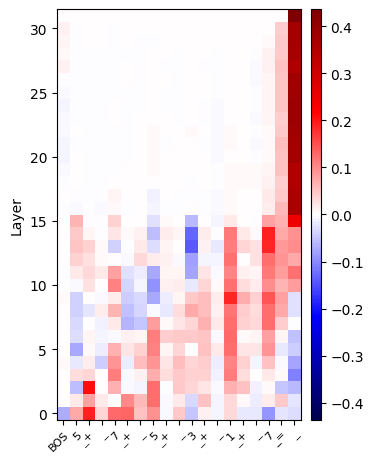

In [30]:
plot_igrads(igrads, tokens)
None

Now that you've completed this notebook, try testing a deeper model! If you'd like to use NDIF to remotely run these experiments, you can see NDIF-hosted models here: https://nnsight.net/status/